<a href="https://colab.research.google.com/github/meucham11/Kaggle/blob/master/02_Credit_Card_Fraud/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[참고 커널](https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow)
Neural Net

[참고 커널](https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis) SVM

[참고 커널](https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders) AutoenCoder




In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path


project_dir="kaggle/02_anormaly_detection/01_Credit_Card_Fraud_Detection"
base_path = Path("/content/drive/My Drive")

project_path = base_path / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 대렉토리 위치 : {os.getcwd()}")

현재 대렉토리 위치 : /content/drive/My Drive/kaggle/02_anormaly_detection/01_Credit_Card_Fraud_Detection


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import tensorflow as tf


In [ ]:
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.2.0-rc4
GPU 사용 가능 여부: True


# 데이터 불러오기

In [ ]:
data = pd.read_csv("creditcard.csv")

- 시각이 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과 된 시간 (초)

- V1사용자 ID 및 민감한 기능을 보호하기 위해 PCA 차원 축소 결과 일 수 있음 (v1-v28)

- v28 : id

- Amount : 거래 금액

- Class : 사기 거래의 경우 1, 그렇지 않은 경우 0

In [ ]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

### 시간에 따른 정상/사기 발생 수

In [ ]:
data['Class'].value_counts() # 0:정상  1:사기

0    284315
1       492
Name: Class, dtype: int64

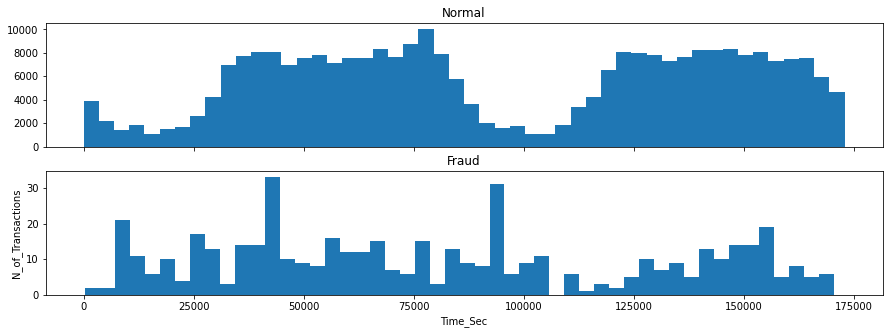

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(15,5))

ax1.hist(data[data['Class'] == 0]['Time'],bins=50)
ax1.set_title('Normal')

ax2.hist(data[data['Class'] == 1]['Time'],bins=50)
ax2.set_title('Fraud')

plt.xlabel('Time_Sec')
plt.ylabel('N_of_Transactions')

plt.show()

### 금액별 정상/사기 거래 횟수

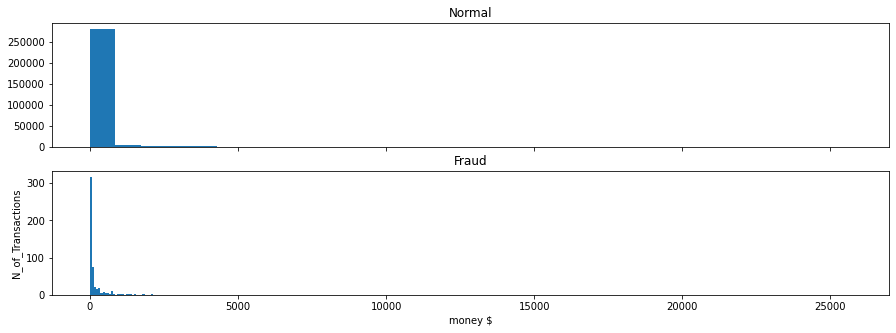

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(15,5))

ax1.hist(data[data['Class']==0]['Amount'], bins=30)
ax1.set_title('Normal')
ax2.hist(data[data['Class']==1]['Amount'], bins=30)
ax2.set_title('Fraud')

plt.xlabel('money $')
plt.ylabel('N_of_Transactions')

plt.show()

↑정상거래의 경우 소액의 거래량이 압도적으로 많기 때문에 뒷 부분이 나오지 않는다.

----

V 변수들에 대해 시각화 해보자

In [ ]:
v_features = data.columns[1:29]
v_features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

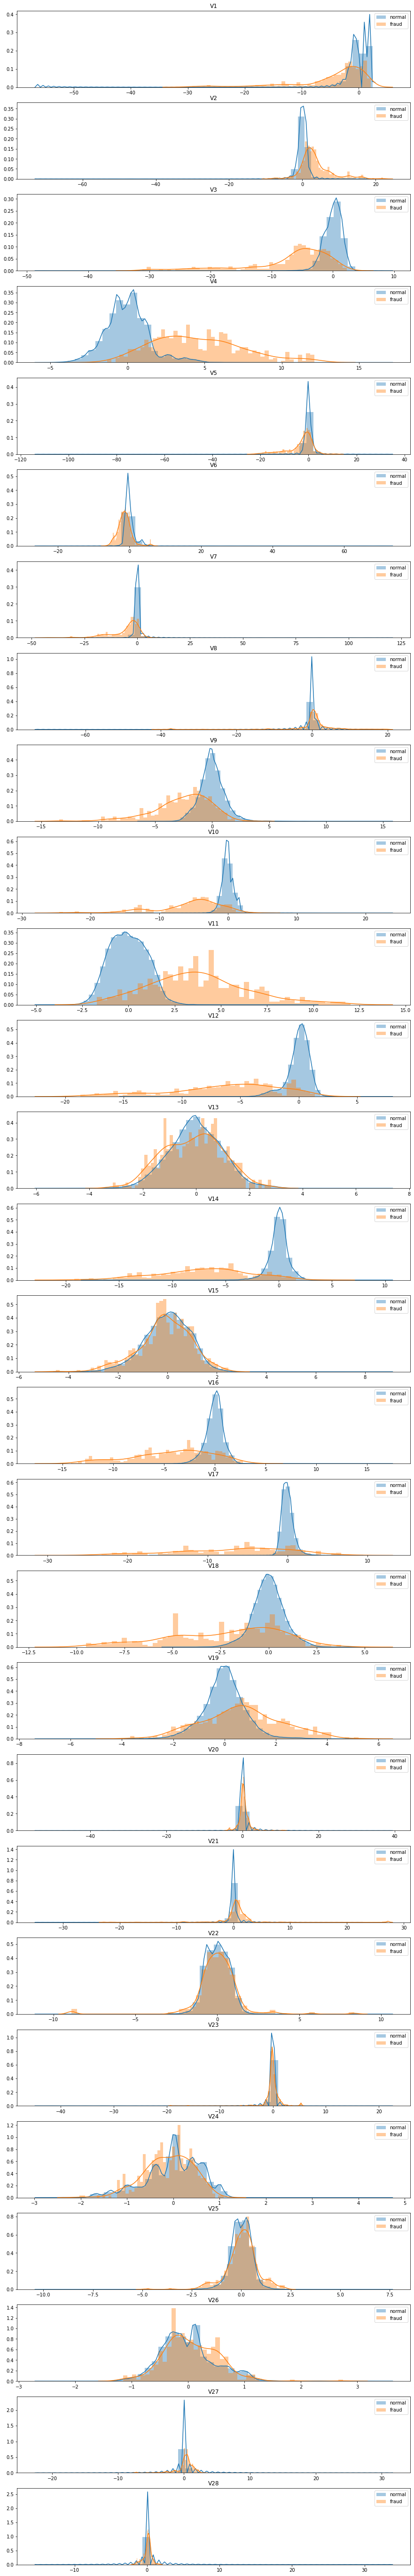

In [ ]:
plt.figure(figsize=(15,100))
gs = gridspec.GridSpec(28, 1)
for i, v in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[data['Class']==0][v], bins=50)
    sns.distplot(data[data['Class']==1][v], bins=50)
    ax.set_title(v)
    ax.legend(['normal','fraud'])
    ax.set_xlabel('')
plt.show()

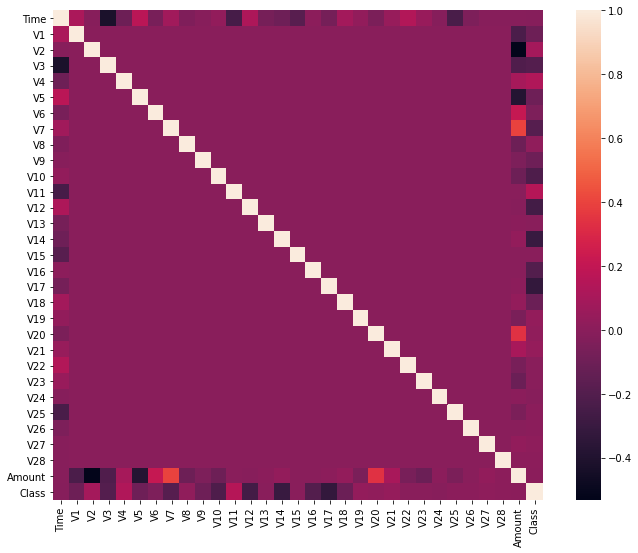

In [ ]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,square = True)
plt.show()

### 분포가 비슷한 변수들을 버려주자

In [ ]:
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)


In [ ]:
data_backup=data.copy()

분포를보고 Fraud와 Normal을 구분할 수 있는 임계값을 찾아 나누어 주자

In [ ]:
data['V1_'] = data.V1.map(lambda x: 1 if x < -3 else 0)
data['V2_'] = data.V2.map(lambda x: 1 if x > 2.5 else 0)
data['V3_'] = data.V3.map(lambda x: 1 if x < -4 else 0)
data['V4_'] = data.V4.map(lambda x: 1 if x > 2.5 else 0)
data['V5_'] = data.V5.map(lambda x: 1 if x < -4.5 else 0)
data['V6_'] = data.V6.map(lambda x: 1 if x < -2.5 else 0)
data['V7_'] = data.V7.map(lambda x: 1 if x < -3 else 0)
data['V9_'] = data.V9.map(lambda x: 1 if x < -2 else 0)
data['V10_'] = data.V10.map(lambda x: 1 if x < -2.5 else 0)
data['V11_'] = data.V11.map(lambda x: 1 if x > 2 else 0)
data['V12_'] = data.V12.map(lambda x: 1 if x < -2 else 0)
data['V14_'] = data.V14.map(lambda x: 1 if x < -2.5 else 0)
data['V16_'] = data.V16.map(lambda x: 1 if x < -2 else 0)
data['V17_'] = data.V17.map(lambda x: 1 if x < -2 else 0)
data['V18_'] = data.V18.map(lambda x: 1 if x < -2 else 0)
data['V19_'] = data.V19.map(lambda x: 1 if x > 1.5 else 0)
data['V21_'] = data.V21.map(lambda x: 1 if x > 0.6 else 0)

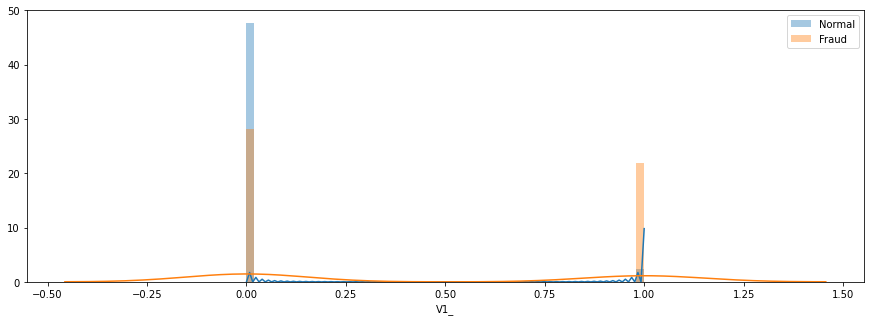

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(data[data['Class']==0]['V1_'], bins=50)
sns.distplot(data[data['Class']==1]['V1_'], bins=50)
plt.legend(['Normal','Fraud'])
plt.show()

Normal과 Fraud를 더미변수화 해준다.

In [ ]:
data.loc[data['Class']==0,"Normal"]=1
data.loc[data['Class']==1,"Normal"]=0

In [ ]:
data=data.rename(columns={'Class':'Fraud'})

In [ ]:
data[data['Fraud']==1]['Amount'].max()

2125.87

In [ ]:
data['Amount_max_fraud'] = 1
data.loc[data.Amount <= 2125.87, 'Amount_max_fraud'] = 0

In [ ]:
data_backup=data.copy()

In [ ]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal,Amount_max_fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,1.914428,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,-0.682920,0.213454,0.77,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1.0,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.584800,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,-1.545556,0.214205,24.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.432454,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,-0.577252,0.232045,67.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.392087,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,2.897849,0.265245,10.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0


----

# DataSet

In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [ ]:
# Only Fraud
Fraud = data[data['Fraud']==1]

# Only Normal
Normal = data[data['Normal']==1]

#### Split X_train, X_test

In [ ]:
F_train = Fraud.sample(frac=0.8)
N_train = Normal.sample(frac=0.8)

count_Frauds = len(F_train)

X_train = pd.concat([F_train,N_train],axis=0)
X_test = data.loc[~data.index.isin(X_train.index)]

X_train = shuffle(X_train)
X_test = shuffle(X_test)

#### Split y_train, y_test

In [ ]:
y_train = X_train[['Fraud','Normal']]
y_test = X_test[['Fraud','Normal']] 

In [ ]:
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

227846
227846
56961
56961


Normalization

In [ ]:
for feature in features:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:,feature] = (X_train[feature] - mean) / std
    X_test.loc[:,feature] = (X_test[feature] - mean) / std

## train

make validation set

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100,activation='tanh',input_dim=37))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50,activation='tanh'))
model.add(tf.keras.layers.Dense(100,activation='tanh'))
model.add(tf.keras.layers.Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 100)               3800      
_________________________________________________________________
dense_67 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_68 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_69 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 202       
Total params: 16,702
Trainable params: 16,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_path = "./ckp/{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True, verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adadelta(), 
              metrics=['accuracy']
              )

In [ ]:
model.fit(X_train.values, y_train.values, 
          validation_split = 0.25,
          epochs= 10,
          shuffle=True,
          callbacks= [cp_callback])

Epoch 1/10
5339/5341 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.9186
Epoch 00001: saving model to ./ckp/0001.ckpt
5341/5341 [==============================] - 18s 3ms/step - loss: 0.3347 - accuracy: 0.9186 - val_loss: 0.0771 - val_accuracy: 0.9985
Epoch 2/10
5326/5341 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9982
Epoch 00002: saving model to ./ckp/0002.ckpt
5341/5341 [==============================] - 18s 3ms/step - loss: 0.0342 - accuracy: 0.9982 - val_loss: 0.0165 - val_accuracy: 0.9985
Epoch 3/10
5327/5341 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9982
Epoch 00003: saving model to ./ckp/0003.ckpt
5341/5341 [==============================] - 17s 3ms/step - loss: 0.0150 - accuracy: 0.9982 - val_loss: 0.0121 - val_accuracy: 0.9985
Epoch 4/10
5332/5341 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9982
Epoch 00004: saving model to ./ckp/0004.ckpt
5341/5341 [===============

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
result=model(X_test)

In [ ]:
np.array(result)

array([[4.6447862e-04, 9.9953556e-01],
       [3.3002876e-04, 9.9967003e-01],
       [6.7538285e-04, 9.9932468e-01],
       ...,
       [2.1581273e-04, 9.9978417e-01],
       [1.4147082e-03, 9.9858534e-01],
       [1.6124471e-03, 9.9838758e-01]], dtype=float32)

In [ ]:
result=round(pd.DataFrame(np.array(result)),0)

In [ ]:
result

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
56956,0.0,1.0
56957,0.0,1.0
56958,0.0,1.0
56959,0.0,1.0


In [ ]:
y_test

,Fraud,Normal
38840,0,1.0
145359,0,1.0
33347,0,1.0
81435,0,1.0
179214,0,1.0
...,...,...
248565,0,1.0
10698,0,1.0
130778,0,1.0
173562,0,1.0


In [ ]:
y_test.sum(0)

Fraud        98.0
Normal    56863.0
dtype: float64

In [ ]:
y_train

,Fraud,Normal
246171,0,1.0
258471,0,1.0
221,0,1.0
86582,0,1.0
150530,0,1.0
...,...,...
121493,0,1.0
176111,0,1.0
1325,0,1.0
27554,0,1.0


In [ ]:
y_train.sum(0)

Fraud        394.0
Normal    227452.0
dtype: float64